**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.** 



In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Ellipse
from IPython.utils.capture import capture_output
from scipy.spatial import distance_matrix
from IPython.display import display, HTML

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
point_color = (0, 0, 1)
active_point_color = (0.3, 0.3, 1)
cluster_color = (0.4, 0.4, 0.7)
active_cluster_color = (0.6, 0.6, 0.8)

def make_ellipse(pointA, pointB, color=active_cluster_color,
                 alpha=0.3, ax=None):
    if ax is None:
        ax = plt.gca()
        
    if pointA[1] < pointB[1]:
        pointA, pointB = pointB, pointA
    
    ABdist = np.linalg.norm(pointA - pointB)
    center = (pointA + pointB) / 2
    angle = np.arccos((pointA[0] - pointB[0]) / ABdist) / np.pi*180
                       
    ellipse = Ellipse(
        xy=center, width=ABdist + 10,
        height=(ABdist + 10)/2, angle=angle,
        alpha=alpha, facecolor=color
    )
    
    ax.add_artist(ellipse)

def point_sizes(point_counts):
    """
    An auxiliary function for calculating the point sizes.
    """
    return (point_counts - 1)*100 + 50

def plot_data(data, color=point_color, ax=None,
              labels='ABCDEFGHIJKLMNOPQRSTUVXYZ',
              c=None, s=50):
    if ax is None:
        ax = plt.gca()

    if c is None:
        ax.scatter(data[:, 0], data[:, 1], s=s, color=color)
    else:
        ax.scatter(data[:, 0], data[:, 1], s=s, c=c)
        
    for i in range(data.shape[0]):
        if not labels[i] is None and len(labels[i]) != 0:
            ax.annotate(labels[i], xy=(data[i, 0], data[i, 1]),
                        xytext=(data[i, 0] - 1, data[i, 1] + 2))
    
    ax.set_aspect('equal')
    ax.grid(ls='--')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_axisbelow(True)

class DummyContext:
    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        pass

def plot_hierarchical_clustering(
    data, linkage_method='centroid',
    figsize=(6, 5),
    fig_fname_step='output/hierarchical_algo_{}.svg',
    fig_fname_dendrogram='output/hierarchical_algo_dendrogram.svg',
    show_steps_inline=True,
    show_dendrogram_inline=True,
    point_color=point_color,
    cluster_color=cluster_color,
    active_point_color=active_point_color,
    active_cluster_color=active_cluster_color,
    labels='ABCDEFGHIJKLMNOPQRSTUVXYZ'
):
    # we compute the distance matrix
    D = squareform(squareform(pdist(data)))
    # we compute the linkage matrix
    Y = sch.linkage(D, method=linkage_method)
    
    deleted = set()
    points = list(data.copy())
    points_count = [1 for i in range(data.shape[0])]
    figs = []

    xlim = None
    ylim = None
    
    with DummyContext() if show_steps_inline else capture_output():
        # go over each row of the linkage matrix
        for Y_row_i, (p1, p2, _, _) in enumerate(Y):
            fig = plt.figure(figsize=figsize)
            figs.append(fig)
            p1 = int(p1); p2 = int(p2)

            # mark p1 and p2 as deleted to suppress them in further plots
            deleted.add(p1)
            deleted.add(p2)

            # gather the points to be plotted
            to_plot = []
            to_plot_labels = []
            colors = []

            for i in range(len(points)):
                if not i in deleted:
                    to_plot.append(i)
                    
                    if i < len(data):
                        to_plot_labels.append(labels[i])
                    else:
                        to_plot_labels.append(None)

                    # different colors for original points and for clusters
                    if i >= data.shape[0]:
                        colors.append(cluster_color)
                    else:
                        colors.append(point_color)

            # compute the weight (number of points) of the new cluster
            points_count.append(points_count[int(p1)] + points_count[int(p2)])
            # add the new cluster into the list of points
            points.append((points[int(p1)] * points_count[int(p1)] +
                          points[int(p2)] * points_count[int(p2)]) / points_count[-1])

            # plot the gathered points
            ar_points = np.asarray(points)
            plot_data(ar_points[to_plot, :], labels=to_plot_labels, c=colors,
                      s=point_sizes(np.asarray(points_count)[to_plot]))
            
            # plot the active points in a different color and plot the new cluster
            # as an ellipse and its centroid as a cross
            plt.scatter(ar_points[[p1, p2], 0], ar_points[[p1, p2], 1],
                        color=active_point_color,
                        s=point_sizes(np.asarray(points_count)[[p1, p2]]), lw=0)
            plt.scatter(ar_points[-1, 0], ar_points[-1, 1], c='r',
                        marker='+', s=50)
            make_ellipse(points[p1], points[p2], ax=plt.gca(),
                         color=active_cluster_color)

            if xlim is None:
                xlim = plt.gca().get_xlim()
                ylim = plt.gca().get_ylim()
            else:
                plt.gca().set_xlim(xlim)
                plt.gca().set_ylim(ylim)

            plt.gca().set_aspect('equal')
            plt.show()

            if not fig_fname_step is None:
                fig.savefig(fig_fname_step.format(Y_row_i),
                            bbox_inches='tight', pad_inches=0)
    
        # display the final cluster
        fig = plt.figure(figsize=figsize)
        figs.append(fig)
        plt.grid(ls='--')
        ar_points = np.asarray(points)
        plot_data(ar_points[-1:, :], color=cluster_color, labels=[None],
                  s=(np.asarray(points_count)[-1] - 1)*100 + 50)

        if not xlim is None:
            plt.gca().set_xlim(xlim)
            plt.gca().set_ylim(ylim)
            
        plt.gca().set_aspect('equal')
        plt.show()

        if not fig_fname_step is None:
            fig.savefig(fig_fname_step.format('final'),
                        bbox_inches='tight', pad_inches=0)

    with DummyContext() if show_dendrogram_inline else capture_output():
        # display the dendrogram
        fig = plt.figure(figsize=figsize)
        figs.append(fig)
        G = sch.dendrogram(Y, color_threshold=0, labels=labels[:data.shape[0]])
        plt.grid(ls='--')
        plt.ylabel("distance")
        plt.show()

        if fig_fname_dendrogram:
            fig.savefig(fig_fname_dendrogram,
                        bbox_inches='tight', pad_inches=0)
    
    return figs

def display_distance_matrix(
    data, labels='ABCDEFGHIJKLMNOPQRSTUVXYZ', return_matrix=False,
    number_format='{:.2f}'
):
    dmat = distance_matrix(data, data)

    # print dmat as an HTML table
    html_table = "<table>"

    html_table += "<tr><th></th>"
    for i in range(data.shape[0]):
        html_table += "<th><strong>" + labels[i] + "</strong></th>"
    html_table += "</tr>"

    # find the row and the column with the minimum distance using argmin
    dmat[np.diag_indices(dmat.shape[0])] = None
    min_row, min_col = np.unravel_index(np.nanargmin(dmat), dmat.shape)

    for i in range(dmat.shape[0]):
        html_table += "<tr><td><strong>{}</strong></td>".format(labels[i])
        for j in range(dmat.shape[1]):
            if i == j:
                html_table += "<td>-</td>"

            elif i < j:
                if (i == min_row and j == min_col) or (i == min_col and j == min_row):
                    html_table += ("<td><strong>" + number_format + "</strong></td>").format(dmat[i, j])
                else:
                    html_table += ("<td>" + number_format + "</td>").format(dmat[i,j])

            else:
                html_table += "<td></td>"
            
        html_table += "</tr>"
        
    html_table += "</table>"

    # display the table in the notebook
    display(HTML(html_table))

    if return_matrix:
        return dmat

## Hierarchical Clustering

We are going to cover hierarchical clustering next: among its advantages is that it is relatively simple, it is not constrained to Euclidean spaces and it comes with a natural way to visualize the structure of the clusters, called a **dendrogram** . Also, the number of clusters does not need to be specified beforehand. On the other hand, the main disadvantage of hierarchical clustering is that it is computationally expensive and therefore not really suited to large datasets. 

There are two paradigms in hierarchical clustering [[ESL]](#ESL):

* agglomerative (bottom-up);
* divisive (top-down).
In agglomerative clustering (a.k.a. bottom-up clustering) the process starts at the bottom [[ESL]](#ESL):

# Each point is assigned its own separate cluster.
# We select the pair of clusters which are closest to each other.
# We join the selected pair of clusters, forming a new, larger cluster.
# We repeat steps 2 and 3 until all points are in the same cluster.
The principle is also explained in a slightly more formal way in the algorithm below.

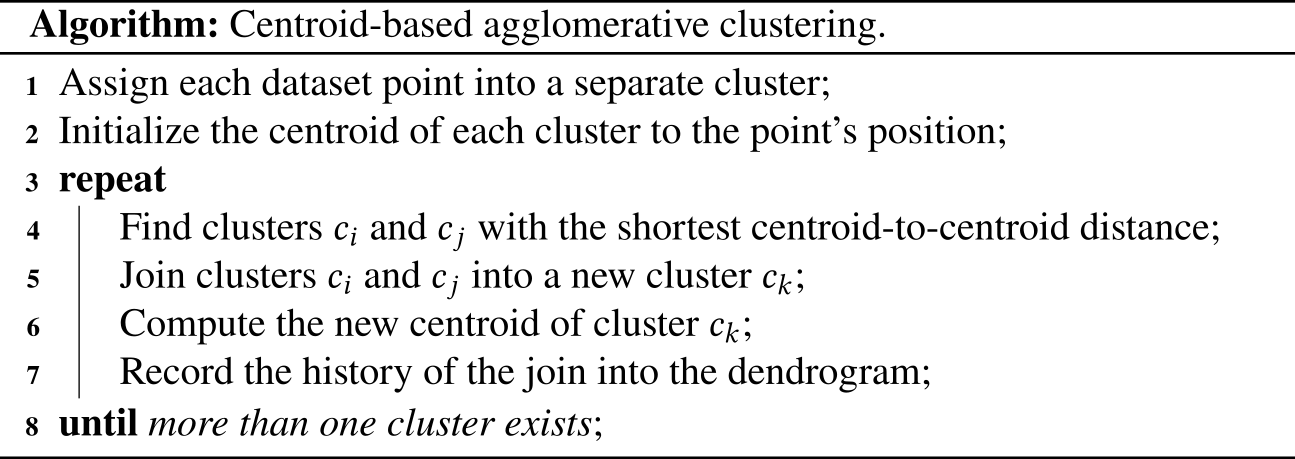

In divisive clustering, we would proceed in the other direction: we would start with a single cluster, which we would gradually divide into smaller ones until each cluster would only contain a single point. The clusters are divided so as to maximize some kind of distance between the newly created subclusters.

### A Visual Example

Next we are going to go over a visual illustration of the entire process using a simple 2-dimensional example. Let us first create a small dataset:



In [ ]:
data = np.array([
    [119.76 , 136.   ],
    [172.26 , 141.   ],
    [149.775, 116.   ],
    [ 82.275,  71.   ],
    [ 48.51 ,  56.   ],
    [ 76.5  ,  51.   ]
])

In [ ]:
fig = plt.figure(figsize=(6, 5))
plot_data(data)

Now, we said that in the first step, the clustering procedure is going to pick the two points with the smallest distance between them and join those into a cluster. Let's check which points that would be in our case by displaying Euclidean distances between all our points and highlighting the smallest one.



In [ ]:
display_distance_matrix(data)

It seems that the smallest distance is between points D and F so those should be joined first. The cell below is going to display all the individual steps of the clustering procedure. Check whether points D and F indeed form the first cluster with 2 points.



In [ ]:
figs = plot_hierarchical_clustering(data, show_dendrogram_inline=False)

Finally, let's also display the dendrogram describing the hierarchical structure of the resulting clustering. We are going to replot the original dataset next to the dendrogram to make it easier to check which points got joined with which and in what order.

Note, the dendrogram we are displaying here was created by our custom demo function, but we are going to show in a later notebook how to use hierarchical clustering in practice and also construct dendrograms and other kinds of accompanying visualizations.



In [ ]:
display(figs[-1])
plot_data(data)

### Hierarchical Clustering in Non-Euclidean Spaces

Now, in our little demo, we assumed that each cluster is going to be represented by its centroid and intercluster distances will be measured using Euclidean distances between those centroids. This would, of course, be an issue, when working in non-Euclidean spaces, where distances are defined otherwise and forming a centroid might not even make sense – the result might not even be a valid point.

In such spaces, we might adopt the strategy used by the $k$-medoids algorithm and select the most representative actual point of each cluster to represent the cluster. However, given that what we really need here is just a way to compute distance between clusters, the more usual way to solve this is to pick a cluster distance metric that does not make the Euclidean space assumption.

One thing that we can always do is compute any kind of distance we require between individual points from the two clusters. We can then decide which of these distances to use and how to determine the overall cluster distance. There are several common ways to do this – if you have a look at the interface of [`AgglomerativeClustering` in scikit-learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), you will see that you can use the `linkage` argument to choose which will be used. 

In any case, having computed the distances between all pairs of points from the first and the second cluster, you can use e.g. [[mmds2014]](#mmds2014):

* The **maximum distance (complete or maximum linkage)** ;
* The **minimum distance (single linkage)** ;
* The **average distance (average linkage)** ;
As a further alternative, you can even try to join clusters together, measure the variance in the resulting clusters and select the least-variance option [[mmds2014]](#mmds2014). This is sometimes referred to as the **ward linkage**  and in scikit-learn, this is the **default approach** .



### References

<a id="ESL">[ESL]</a> Hastie, T. – Tibshirani, R. – Friedman, J. The Elements of Statistical Learning. Springer, 2009, second edition. ISBN 978-0-387-84858-7.

<a id="mmds2014">[mmds2014]</a> Rajaraman, A. and Ullman, J.D., 2011. Mining of massive datasets. Cambridge University Press. URL: <http://infolab.stanford.edu/~ullman/mmds/book.pdf>.



In [ ]:
latex_out = latex2svg(r"""
\begin{algorithm}[H]
Assign each dataset point into a separate cluster\;
Initialize the centroid of each cluster to the point's position\;

\Repeat{more than one cluster exists}{
Find clusters $c_i$ and $c_j$ with the shortest centroid-to-centroid distance\;
Join clusters $c_i$ and $c_j$ into a new cluster $c_k$\;
Compute the new centroid of cluster $c_k$\;
Record the history of the join into the dendrogram\;
}

\caption{Centroid-based agglomerative clustering.}
\label{alg:agglomerative_clustering}
\end{algorithm}
""", params=params
)

with open("gen_images/agglomerative_clustering.svg", "w") as file:
    file.write(latex_out['svg'])
    
display(SVG(latex_out['svg']))